In [164]:
import pymongo
import pandas as pd
import numpy as np
from datetime import date
from dateutil import parser as date_parser
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.trading
collection = db.GOOGL

In [4]:
df = pd.DataFrame(list(collection.find()))

In [5]:
df

,_id,date,open,high,low,close,volume,symbol
0,5f5b3d980769b13fd6ebb649,2020-09-10T00:00:00.000Z,1550.18,1573.66,1520.0000,1526.050,1651194.0,GOOGL
1,5f5b3d980769b13fd6ebb64a,2020-09-09T00:00:00.000Z,1548.90,1558.72,1525.1700,1547.230,1962078.0,GOOGL
2,5f5b3d980769b13fd6ebb64b,2020-09-08T00:00:00.000Z,1525.00,1555.55,1516.5000,1523.600,2701586.0,GOOGL
3,5f5b3d980769b13fd6ebb64c,2020-09-04T00:00:00.000Z,1609.00,1634.99,1537.9701,1581.210,2792533.0,GOOGL
4,5f5b3d980769b13fd6ebb64d,2020-09-03T00:00:00.000Z,1699.52,1700.00,1607.7100,1629.510,3186287.0,GOOGL
...,...,...,...,...,...,...,...,...
4039,5f5b3d980769b13fd6ebc610,2004-08-25T00:00:00.000Z,104.76,108.00,103.8800,106.000,9188600.0,GOOGL
4040,5f5b3d980769b13fd6ebc611,2004-08-24T00:00:00.000Z,111.24,111.60,103.5700,104.870,15247300.0,GOOGL
4041,5f5b3d980769b13fd6ebc612,2004-08-23T00:00:00.000Z,110.76,113.48,109.0500,109.400,18256100.0,GOOGL
4042,5f5b3d980769b13fd6ebc613,2004-08-20T00:00:00.000Z,101.01,109.08,100.5000,108.310,22834300.0,GOOGL


In [6]:
df2 = df[['date', 'symbol', 'open', 'close', 'high', 'low', 'volume']]

In [7]:
df2['date'] = pd.to_datetime(df2['date']).dt.tz_localize(None)

<ipython-input-7-6ebc0551d850>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] = pd.to_datetime(df2['date']).dt.tz_localize(None)


In [8]:
df2

,date,symbol,open,close,high,low,volume
0,2020-09-10,GOOGL,1550.18,1526.050,1573.66,1520.0000,1651194.0
1,2020-09-09,GOOGL,1548.90,1547.230,1558.72,1525.1700,1962078.0
2,2020-09-08,GOOGL,1525.00,1523.600,1555.55,1516.5000,2701586.0
3,2020-09-04,GOOGL,1609.00,1581.210,1634.99,1537.9701,2792533.0
4,2020-09-03,GOOGL,1699.52,1629.510,1700.00,1607.7100,3186287.0
...,...,...,...,...,...,...,...
4039,2004-08-25,GOOGL,104.76,106.000,108.00,103.8800,9188600.0
4040,2004-08-24,GOOGL,111.24,104.870,111.60,103.5700,15247300.0
4041,2004-08-23,GOOGL,110.76,109.400,113.48,109.0500,18256100.0
4042,2004-08-20,GOOGL,101.01,108.310,109.08,100.5000,22834300.0


In [362]:
#df2 = df2.set_index('date')

In [9]:
df3 = df2[['date', 'open']]

In [10]:
df3 = df3.resample('1440Min', on='date').first().drop('date', 1).reset_index()

In [12]:
#df3 = df3.dropna()

In [11]:
df3 = df3.fillna(method='ffill')

In [12]:
df3

,date,open
0,2004-08-19,100.01
1,2004-08-20,101.01
2,2004-08-21,101.01
3,2004-08-22,101.01
4,2004-08-23,110.76
...,...,...
5862,2020-09-06,1609.00
5863,2020-09-07,1609.00
5864,2020-09-08,1525.00
5865,2020-09-09,1548.90


In [18]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 

In [19]:
df4 = df3.set_index('date')

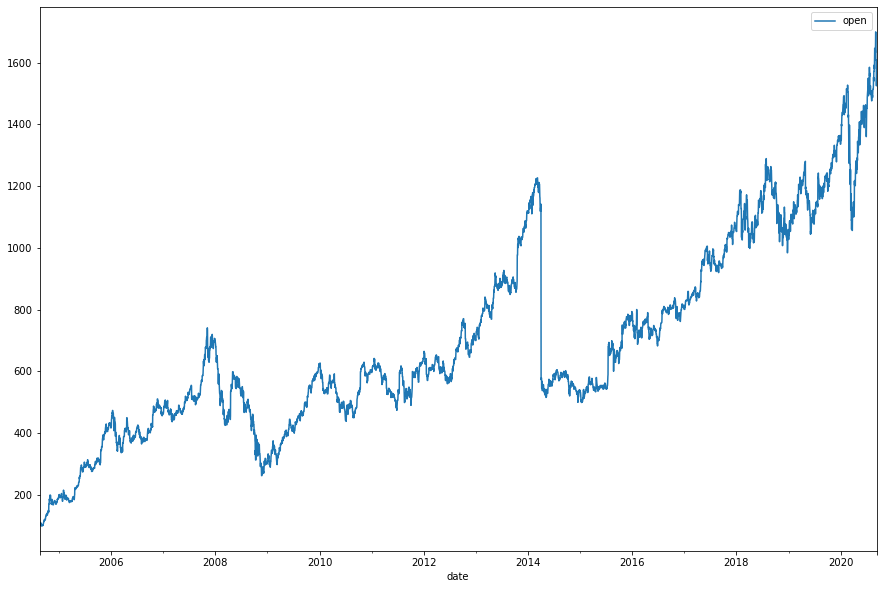

In [21]:
df4.plot(figsize=(15,10))

In [81]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df4[['open']][:1955].values)
X_val = scaler.transform(df4[['open']][1955:3911].values)
X_test = scaler.transform(df4[['open']][3911:].values)

In [82]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [83]:
X_train, y_train = split_sequence(X_train, 12)
X_val, y_val = split_sequence(X_val, 12)
X_test, y_test = split_sequence(X_test, 12)

In [84]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [85]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [86]:
model = Sequential([
    LSTM(20, activation="relu", input_shape=X_train.shape[1:]), # or (X_train.shape[1], 1) or (n_steps, n_features)
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [87]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10,
                          restore_best_weights=True) 

In [88]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size = 32,
                    callbacks=early_stopping_cb)

Epoch 1/100
61/61 [==============================] - 1s 16ms/step - loss: 0.0549 - val_loss: 0.0065
Epoch 2/100
61/61 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0170
Epoch 3/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0315
Epoch 4/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0362
Epoch 5/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0299
Epoch 6/100
61/61 [==============================] - 1s 10ms/step - loss: 9.6269e-04 - val_loss: 0.0287
Epoch 7/100
61/61 [==============================] - 1s 10ms/step - loss: 8.9760e-04 - val_loss: 0.0218
Epoch 8/100
61/61 [==============================] - 1s 10ms/step - loss: 8.3060e-04 - val_loss: 0.0154
Epoch 9/100
61/61 [==============================] - 1s 10ms/step - loss: 7.7827e-04 - val_loss: 0.0102
Epoch 10/100
61/61 [==============================] - 1s 10ms/step - loss: 7.3256e-0

In [89]:
mse_test = model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 3ms/step - loss: 0.0111


In [90]:
rmse = np.sqrt(mse_test)
print(rmse)

0.10535869772952353


In [99]:
mse_test = model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 3ms/step - loss: 0.0111


In [94]:
predicted_open = model.predict(X_test)
predicted_open = scaler.inverse_transform(predicted_open)

In [104]:
prediction = pd.Series(predicted_open[-720:].reshape(-1), index = df4['open'].iloc[-720:].index)

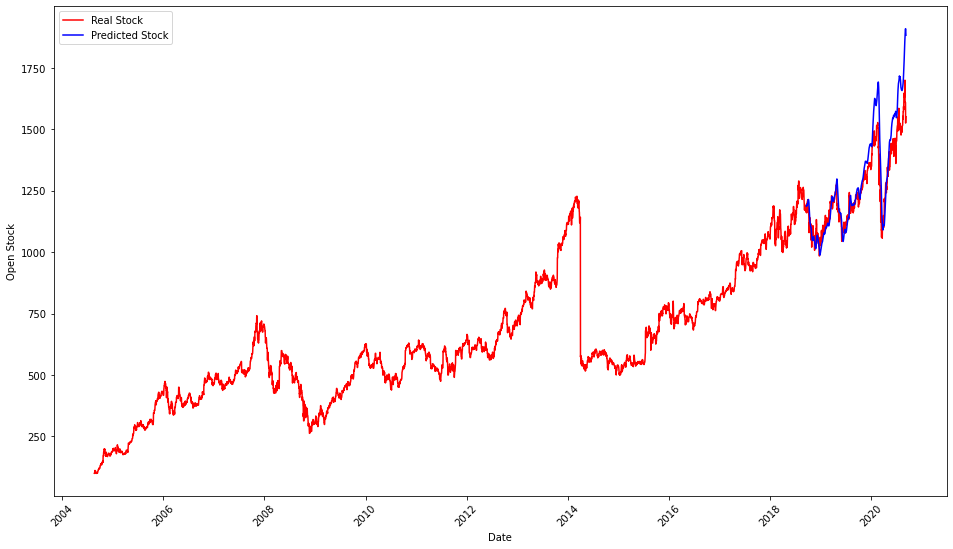

In [105]:
plt.plot(df4['open'], color = 'r', label = 'Real Stock')
plt.plot(prediction, color = 'b', label = 'Predicted Stock')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Open Stock')
plt.legend()
plt.show()

In [111]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df4['open'],predicted_open[-12:]))

ValueError: Found input variables with inconsistent numbers of samples: [5867, 12]

In [146]:
from pygooglenews import GoogleNews
import pprint
gn = GoogleNews()
top = gn.top_news()
# gn = GoogleNews(lang = 'cn', country = 'CN')
# top = gn.top_news()
# business = gn.topic_headlines('BUSINESS')
search = gn.search('MSFT', when = '1d')
entries = search['entries']   

In [192]:
data = pd.DataFrame(columns = ['Author', 'Date', 'Title', 'Link'])

In [193]:
for entrie in entries :
    data = data.append(pd.Series({'Author': entrie.source.title, \
                           'Date': date_parser.parse(entrie.published),\
                           'Title': entrie.title, \
                           'Link': entrie.link \
                          }), \
                ignore_index=True)

In [194]:
data

,Author,Date,Title,Link
0,Yahoo Finance,2020-09-10 16:09:00+00:00,Microsoft (MSFT) And Nutanix Collaborate on Hy...,https://finance.yahoo.com/news/microsoft-msft-...
1,News BUR,2020-09-10 17:21:04+00:00,Here’s Why Microsoft Corporation [MSFT] Stock ...,https://newsbur.com/2020/09/10/heres-why-micro...
2,Seeking Alpha,2020-09-11 08:22:00+00:00,"Russia, China and Iran are targeting U.S. elec...",https://seekingalpha.com/news/3613193-russia-c...
3,Benzinga,2020-09-11 08:52:00+00:00,"TikTok Parent Plots Southeast Asia Expansion, ...",https://www.benzinga.com/news/20/09/17466110/t...
4,Seeking Alpha,2020-09-10 17:34:00+00:00,"Microsoft Teams, NFL deepen gameday partnershi...",https://seekingalpha.com/news/3613029-microsof...
...,...,...,...,...
69,Forbes,2020-09-10 14:00:00+00:00,Should You Be Concerned Because Microsoft’s St...,https://www.forbes.com/sites/greatspeculations...
70,Times Of New York,2020-09-10 15:03:00+00:00,Lot To Expect From These Two Names In The Comi...,https://timesofnewyork.net/index.php/2020/09/1...
71,Pineville,2020-09-10 13:31:21+00:00,Which Way Is Microsoft Corp (MSFT) Trending? -...,https://pinevillevoice.com/which-way-is-micros...
72,Interviewer 99,2020-09-11 13:03:29+00:00,Russian state hackers are concentrated on Bide...,https://interviewer99.com/2020/09/11/russian-s...


datetime.datetime

('‘Keep calm and carry on’: Trump compared himself to Brits in the Blitz. But '
 'that phrase was never used in WWII. - The Washington Post')
"Half a million flee 'unprecedented' Oregon fires - BBC News"
'Trump campaign weighing White House event around Election Day - NBC News'
'4 Houston police officers involved in fatal shooting are fired - CNN'
('Wisconsin Supreme Court temporarily blocks absentee ballots from being '
 'mailed a week before deadline - CNN')
('What to Watch as Biden Observes 9/11 in NY, and He and Trump Go to '
 'Shanksville - The New York Times')
("'Vicious little suckers': Massive clouds of mosquitoes kill cows, horses in "
 'Louisiana after Hurricane Laura - USA TODAY')
('Federal appeals court strikes down Trump administration policy on keeping '
 'undocumented immigrants from bein... - Fox News')
('Money for $300 unemployment boost to run out — with no extension in sight - '
 'Chicago Tribune')
('California sheriff: Deputy burglarized home after responding to dea

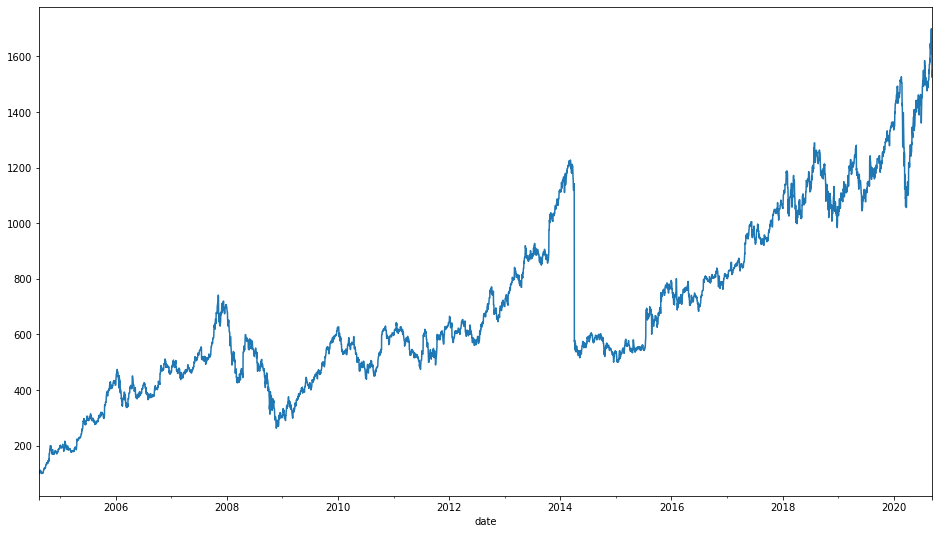

In [391]:
series = TimeSeries.from_dataframe(df3, 'date', 'open','D')
series.plot()

In [404]:
from darts.models import ExponentialSmoothing
train, val = series.split_before(pd.Timestamp('20180101'))

In [406]:
model = ExponentialSmoothing()
model.fit(train)

prediction = model.predict(len(val))

/Users/guoleyang/opt/anaconda3/lib/python3.7/site-packages/darts/models/exponential_smoothing.py:66: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  seasonal_periods=self.seasonal_periods)
/Users/guoleyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


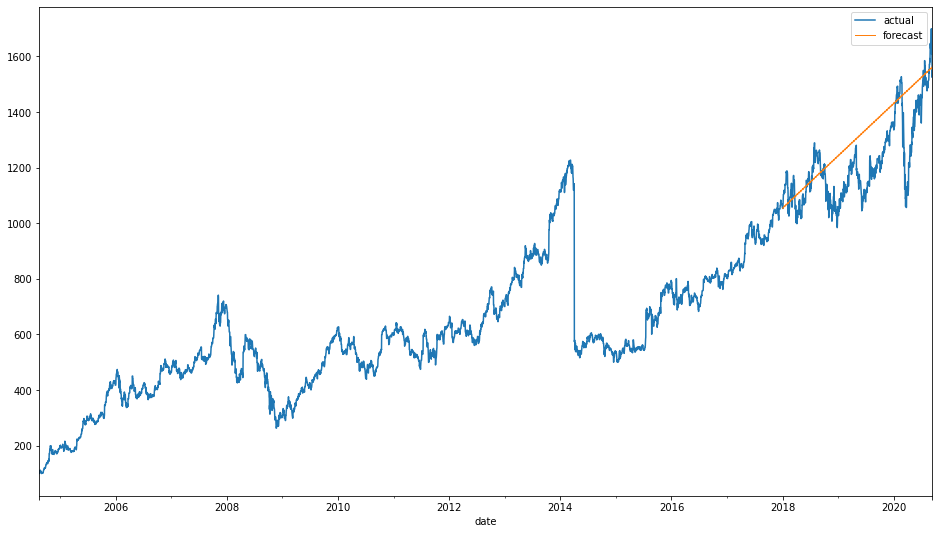

In [407]:
series.plot(label='actual')
prediction.plot(label='forecast', lw=1)
plt.legend()

In [426]:
from darts.models import AutoARIMA
model_aarima = AutoARIMA()

In [410]:
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

/Users/guoleyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/guoleyang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [411]:
prediction_aarima

                      0
2018-01-01  1055.549321
2018-01-02  1055.494934
2018-01-03  1055.544797
2018-01-04  1055.499082
2018-01-05  1055.540994
...                 ...
2020-09-05  1055.520947
2020-09-06  1055.520947
2020-09-07  1055.520947
2020-09-08  1055.520947
2020-09-09  1055.520947

[983 rows x 1 columns]
Freq: D

In [415]:
from darts.backtesting import backtest_forecasting
from darts.models import Prophet

In [418]:
models = [ExponentialSmoothing(), Prophet()]

In [425]:
backtests = [backtest_forecasting(series, model,pd.Timestamp('2020-01-01'), fcast_horizon_n=3) for model in models]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

SystemError: <class 'stanfit4anon_model_861b75c6337e237650a61ae58c4385ef_3827973547975722349.PyStanHolder'> returned a result with an error set

In [ ]:
from darts.metrics import mape
series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
plt.title('Backtests with 3-months forecast horizon')
plt.legend()